In [1]:
#Import all essential libraires such as numpy, pandas, and patlib to notebook for the time series analysis
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# By using Panda's csv read function to read the csv file of Currency pair exchange rates for CAD/JPY, set the "Date" column as index column.  We will parse the date in date time object.
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# We will focus the analysis from 1990's to recent period, so we will use the dataframe loc function to trim the dataset to begin on January 1st, 1990 
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

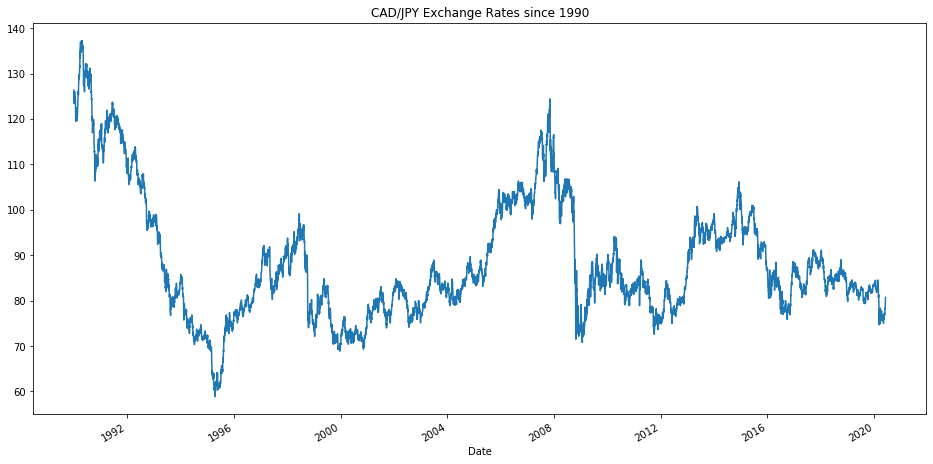

In [4]:
# To see the Price pattern of the exchange rate, we plot the "Price" column against date from the dataframe:
cad_jpy_df_plot = cad_jpy_df ["Price"].plot(figsize =(16,8), title ="CAD/JPY Exchange Rates since 1990")

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** In long-term, the CAD/JPY exchange has been oscillating in the range of 139 to 60 and with the long-term mean of about 95.  In short term, the CAD/JPY exchange rate is oscillating in the 
range of 75 to 90 since 2017 and it seems the rate is undergoing a consolidation with no major upward or downward swing in the recent years.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
#Import the statsmodels library to utilize the Hodrick-Prescott Filter to decompose the trend and noise of the dataset
import statsmodels.api as sm
# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series (Trend and Noise)
cad_jpy_fx_noise, cad_jpy_fx_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"]) 

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
# The new dataframe would only consist the Price, the Noise, and the Trend
data = [cad_jpy_df["Price"], cad_jpy_fx_noise, cad_jpy_fx_trend]
headers = ["Price", "noise", "trend"]

#  Using the concat function to combine the columns of price, noise, trend and store into a new dataframe cad_jpy_fx
cad_jpy_fx = pd.concat(data, axis =1, keys =headers)
cad_jpy_fx.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


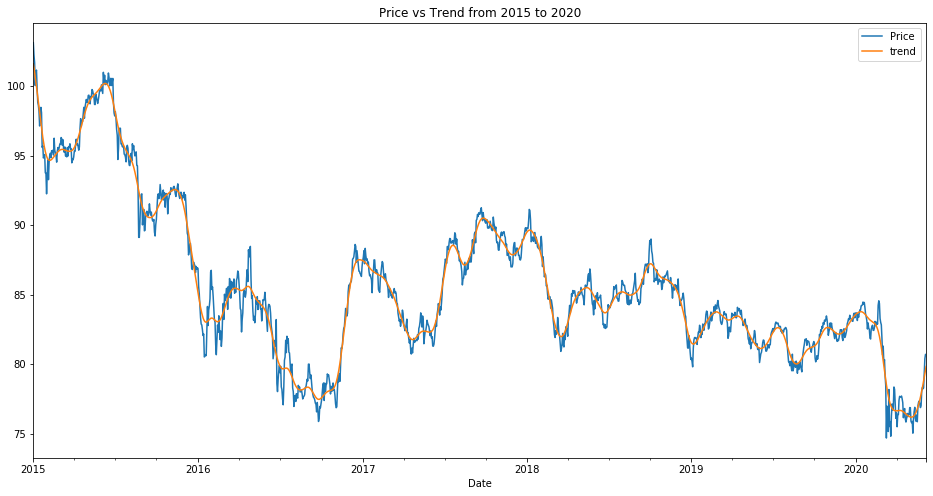

In [7]:
# Using the data in the new dataframe cad_jpy_fx above, we plot the Exchange Rate Price vs. the Trend for 2015 to the present
cad_jpy_fx_2015 = cad_jpy_fx.loc["2015-01-01":,:]
cad_jpy_fx_2015.head()

cad_jpy_fx_2015_plot = cad_jpy_fx_2015.plot(figsize=(16,8), y= ["Price", "trend"], title ="Price vs Trend from 2015 to 2020")

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** In accordance with the Trending graph above, there seems a downward trend for the exchange rate in long-term.  In short-temr, the exchange rate was oscillating in the range of 80 to 85 from year 2018 to 2020, and it experiences downward trend in 2020 due to pandemic's impact. 

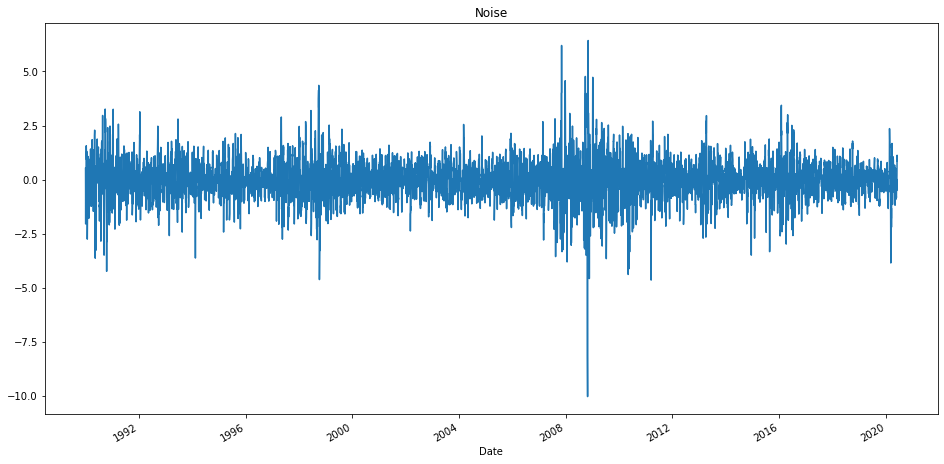

In [8]:
# Plot the Settle Noise
cad_jpy_fx_noise.plot(figsize = (16,8), title = "Noise")

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [22]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [25]:
#Import the statsmodels library to utilize the ARMA model to fit the "return" values from above and to enable the model to make prediction
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1)); p =2 and q = 1 and return values to fit the model
ARMA_model = ARMA(returns.values, order =(2,1))

# Fit the model and assign it to a variable called results
result = ARMA_model.fit()


In [26]:
# Output model summary results:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Wed, 14 Jul 2021   AIC                          19513.955
Time:                        16:04:10   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.201      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.031      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1697           +0.0000j           42.1697            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

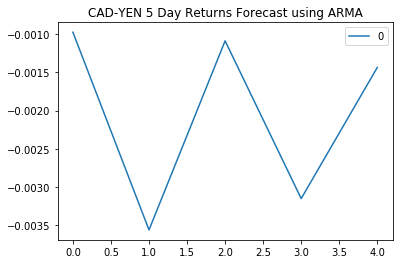

In [31]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(result.forecast(steps=5)[0]).plot(title= "CAD-YEN 5 Day Returns Forecast using ARMA")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** Based on the summary of results, the p-values from one of the significant lags is greater 0.05.  This reveals that the model is not a good fit with existing parameters and variables.  We
need to further explore other alternative solution to make better prediction.  

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [29]:
#Import the statsmodels library to utilize the ARIMA model to fit the "Price" values in the original dataframe and to enable the model to make prediction
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:ARIMA(df, order=(p, d, q)); with p = 5, d = 1 and q = 1
ARIMA_model = ARIMA(cad_jpy_df ["Price"].values, order=(5,1,1))

# Fit the model
ARIMA_result = ARIMA_model.fit()

In [30]:
# Output model summary results:
ARIMA_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 14 Jul 2021   AIC                          17507.244
Time:                        16:14:27   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.y      0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.y      0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.y     -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.y      0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.y     -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.y     -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1892           +0.0000j            2.1892            0.0000
-----------------------------------------------------------------------------
"""

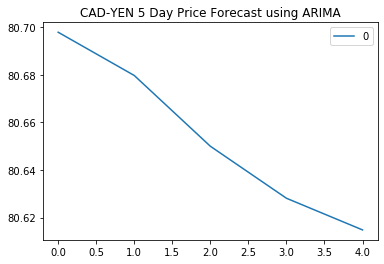

In [33]:
# Plot the 5 Day Price Forecast
pd.DataFrame(ARIMA_result.forecast(steps=5)[0]).plot(title = "CAD-YEN 5 Day Price Forecast using ARIMA")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The ARIMA model predicts that the exchange rate will drop from 80.70 to 80.62 in 5 days forecast.  It is revealing a stronger Japanese YEN in 5 days' forecast using ARIMA model.  

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
#Import the ARCH library to utilize the GARCH model to enable the model to make prediction on near-term volatility of the exchange rate return
import arch as arch

In [37]:
# Estimate a GARCH model; call the GARCH from the libray with p =2  and q =1.
from arch import arch_model
GARCH_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the GARCH model with returns of exchange rate
GARCH_results = GARCH_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 569545243.4284524
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838552966728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11769.086094978014
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.350185312931
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.366479560163
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.111921464748
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027336222945
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.02203125968
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021014202204
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020776838068
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764888566
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.02076489123
Optimization terminated successfully    (Exit mode 0)
          

In [35]:
# Summarize the model results
GARCH_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Wed, Jul 14 2021   Df Residuals:                     7928
Time:                        21:36:17   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [38]:
# To identify the the last day of the original dataset to prepare the operation of forecasting
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [39]:
# We will set a forecast time windows of 5 days of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated and the forecast_horizon above; input all these into GARCH model()
forecasts = GARCH_results.forecast (start = last_day, horizon = forecast_horizon)

In [40]:
# Results from GARCH forecast will need to be Annualized to show the merit of the prediction  
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566035,12.573725,12.581308,12.588786,12.596161


In [41]:
# Transpose the forecast in to dataframe using .T () function so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566035
h.2,12.573725
h.3,12.581308
h.4,12.588786
h.5,12.596161


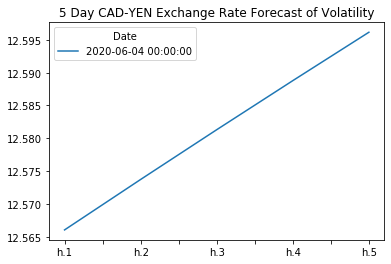

In [42]:
# Plot the final forecast
final.plot(title = "5 Day CAD-YEN Exchange Rate Forecast of Volatility")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** From the results of GARCH model, the volatility of CAD/YEN will increase in 5 day's forecast with the plots showing an increasing trend.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * Based on the results from ARIMA model, there is a sign that the CAD/YEN exchange rate will move downward in 5 days forecast which implies a stronger Japanese Yen in near-term.  
    As a result, it is beneficial to buy Yen now to capture the upward movement.

2. Is the risk of the yen expected to increase or decrease?
    * From the results of GARCH, there is strong tendency of expected increase in risk with 5 days forecast

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * With the results from ARMA, ARIMA and GARCH, I would not be confident to use these models for trading.  The reason is that p-values for the parameters in the models
    still have not met the threshold of 5%.  It would be better off to have a "fit" model with p-values less than 5%.  We still need to modify and perfect our models to make feasible trading decisions.  